    Topic:        Project 1  
    Subject:      Campaign Placement for WomenTechWomenYes Canvassing  
    Date:         07/09/2018  
    Name:         Courtney  
    Worked with:  Tim, Brandon

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from copy import deepcopy

%matplotlib inline

**Read data files from online, concatenate the data and create a pickle file**

* Open up a new Jupyter notebook
* Download a few MTA turnstile data files
* Open up a file, use csv reader to read it, make a python dict where there is a key for each (C/A, UNIT, SCP, STATION).

First, create a function to retrieve the necessary data from April, May and June 2018.

In [ ]:
# Data Source: http://web.mta.info/developers/turnstile.html
def get_data_and_pickle(weeks):
    """
    Retrieve and read data from a website
    ---
    Input: list of ints or strings, or single int/string
    """
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    data = []
    for week in weeks:
        file_url = url.format(week)
        data.append(pd.read_csv(file_url))
    with open('raw_data_mta.pickle', 'wb') as to_write:
        pickle.dump(pd.concat(data), to_write)
    return pd.concat(data)

# Pull data from April, May and June 2018
week_labels = [180630, 180623, 180616, 180609, 180602, 180526, 
               180519, 180512, 180505, 180428, 180421, 180414, 180407]

turnstiles_df = get_data_and_pickle(week_labels)

In [88]:
with open('raw_data_mta.pickle','rb') as read_file:
    turnstiles_df = pickle.load(read_file)

Alternatively if the file is already saved locally in the same
directory as the Jupyter notebook, uncomment & run the below after 
assigning the local data file name to the variable file.

In [60]:
# data_file = 'data_file.txt'
# turnstiles_df = pd.read_csv(data_file)

In [59]:
# turnstiles_df.head()

In [89]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [90]:
turnstiles_df.columns = [column.strip() for column in turnstiles_df.columns]

In [91]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [92]:
turnstiles_df.shape

(2560843, 11)

**Format the date and select columns of interest**

In [93]:
turnstiles_df["DATE_TIME"] = pd.to_datetime(turnstiles_df.DATE + " " + turnstiles_df.TIME, format="%m/%d/%Y %H:%M:%S")

In [94]:
turnstiles_df["DATE"] = pd.to_datetime(turnstiles_df.DATE, format="%m/%d/%Y")

In [95]:
time_series_df = pd.DataFrame(turnstiles_df[['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'ENTRIES', 'EXITS', 'DATE_TIME', 'DATE', 'DESC']])

In [65]:
# time_series_df.head()

In [10]:
# time_series_df.dtypes

**Remove duplicate AUDIT times from the dataset**

In [96]:
time_series_df['DESC'].value_counts(normalize=True)

REGULAR       0.997141
RECOVR AUD    0.002859
Name: DESC, dtype: float64

In [13]:
# time_series_df.shape

In [97]:
mask = (time_series_df["DESC"] == "REGULAR")

In [98]:
time_series_df = deepcopy(time_series_df[mask])

In [17]:
# time_series_df.head()

In [100]:
# time_series_df['DESC'].value_counts(normalize=True)

**Subtract 1 minute from datatime object so that 'midnight' entries register as 11:59pm - as the prior day and not the next day**

In [101]:
time_series_df.loc[:,'DATE_TIME'] = time_series_df.loc[:,'DATE_TIME'] - pd.Timedelta(minutes=1)

In [22]:
# time_series_df.head()

**Create a new Date column with the YYYY-MM-DD format based on the dates after subtracting 1 minute** 

In [102]:
time_series_df.loc[:,'DATE'] = time_series_df.loc[:,'DATE_TIME'].dt.date

In [25]:
# time_series_df.head()

**Look at what the time intervals are between measurements - first sort the dataset so entries are within chronological order** 

In [103]:
# sort by DATE_TIME within station/linenames
time_series_df = deepcopy(time_series_df.sort_values(by=['C/A','UNIT','SCP','STATION','LINENAME','DATE_TIME']))

In [104]:
time_series_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,ENTRIES,EXITS,DATE_TIME,DATE,DESC
0,A002,R051,02-00-00,59 ST,NQR456W,6566463,2224050,2018-03-30 23:59:00,2018-03-30,REGULAR
1,A002,R051,02-00-00,59 ST,NQR456W,6566470,2224053,2018-03-31 03:59:00,2018-03-31,REGULAR
2,A002,R051,02-00-00,59 ST,NQR456W,6566470,2224053,2018-03-31 07:59:00,2018-03-31,REGULAR
3,A002,R051,02-00-00,59 ST,NQR456W,6566470,2224055,2018-03-31 11:59:00,2018-03-31,REGULAR
4,A002,R051,02-00-00,59 ST,NQR456W,6566470,2224055,2018-03-31 15:59:00,2018-03-31,REGULAR


**Pickle the cleaned and sorted dataset before adding new variables**

In [106]:
with open('formatted_raw_mta_data.pickle', 'wb') as to_write:
    pickle.dump(time_series_df, to_write)

**Open the deduped pickle file to begin adding new variables**

In [129]:
with open('formatted_raw_mta_data.pickle','rb') as read_file:
    time_series_df = pickle.load(read_file)

In [130]:
time_series_df.shape

(2553522, 10)

**Get time difference between an entry and the entry before it**

In [131]:
group_vals = ['C/A', 'UNIT', 'SCP','STATION', 'LINENAME']

In [132]:
time_intervals = time_series_df.groupby(by=group_vals)['DATE_TIME'].transform(lambda x: x.diff())

In [135]:
time_intervals.value_counts(normalize=True).head()

04:00:00    0.928307
04:12:00    0.062163
08:00:00    0.002133
04:26:00    0.000714
00:01:20    0.000685
Name: DATE_TIME, dtype: float64

The vast majority of time intervals are 4-hour time intervals.    

In [133]:
time_series_df["TIME_INTERVAL"] = time_intervals

In [35]:
# time_series_df.head()

**Get entries per time interval**

In [136]:
entry_diff_per_turnstile_interval = time_series_df.groupby(by=['C/A', 'UNIT', 'SCP','STATION', 'LINENAME'])['ENTRIES'].transform(lambda x: x.diff())

In [138]:
time_series_df["ENTRY_DIFF"] = entry_diff_per_turnstile_interval

**Check for what percent of entries are negative and should be cleaned from the dataset**

In [139]:
(time_series_df[time_series_df["ENTRY_DIFF"] < 0].shape[0]) /time_series_df.shape[0]

0.008476527713487489

**Get exits per time interval**

In [140]:
entry_diff_per_turnstile_interval = time_series_df.groupby(by=['C/A', 'UNIT', 'SCP','STATION', 'LINENAME'])['EXITS'].transform(lambda x: x.diff())

In [141]:
time_series_df["EXIT_DIFF"] = entry_diff_per_turnstile_interval

In [143]:
# time_series_df.head()

**Check for what percent of exits are negative and should be cleaned from the dataset (check if counters for entry and exit reset at the same or different intervals!)**

In [144]:
(time_series_df[time_series_df["EXIT_DIFF"] < 0].shape[0]) /time_series_df.shape[0]

0.00667352777849574

In [41]:
# time_series_df.shape[0]

**Remove entry and exit counts with negative numbers from the dataset (about 1% of the dataset). This code will also remove null entry and exit values (the first entry or exit value for each date in a turnstile group is null because there is no prior date to compare to)**

In [145]:
time_series_df = time_series_df[time_series_df.ENTRY_DIFF >= 0]

In [146]:
time_series_df = time_series_df[time_series_df.EXIT_DIFF >= 0]

In [147]:
time_series_df.shape

(2519849, 13)

**Check for outrageously high ENTRY values from the 4-hour time intervals**

In [49]:
time_series_df['ENTRY_DIFF'].max()

2105700124.0

##### **Get 99th percentile of entry data**  
This value is very low - because there are many zeros in the dataset for 4-hour intervals where no one went in the subway (12am-4am at smaller stations for example), the confidence interval shifts to the left. We might be better off capping data at 500,000 and seeing how the data looks. 

In [155]:
time_series_df.ENTRY_DIFF.quantile(0.99)

1197.0

**Histogram of entries per 4 hours to see if any are outrageous** 

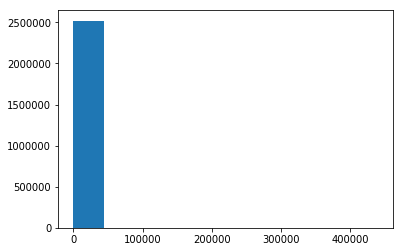

In [156]:
x = list(time_series_df['ENTRY_DIFF'])
plt.hist(x);

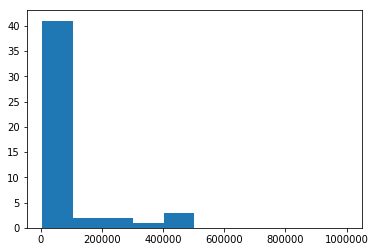

In [157]:
x = list(time_series_df['ENTRY_DIFF'])
plt.hist(x, range=(4000,1000000));

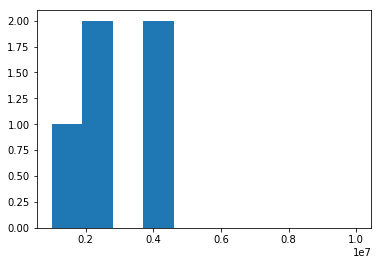

In [151]:
x = list(time_series_df['ENTRY_DIFF'])
plt.hist(x, range=(1000000,10000000));

In [158]:
time_series_df = time_series_df[time_series_df.ENTRY_DIFF < 500000]

In [159]:
time_series_df.shape

(2519811, 13)

**99th percentile of EXIT data**

In [160]:
time_series_df.EXIT_DIFF.quantile(0.99)

1103.0

**Histogram of EXITS per 4 hours to see if any are outrageous** 

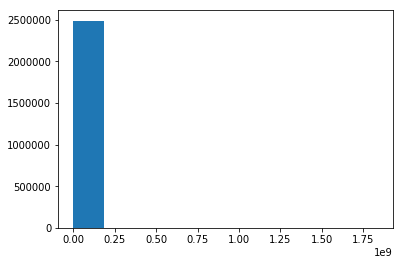

In [75]:
x = list(time_series_df['EXIT_DIFF'])
plt.hist(x);

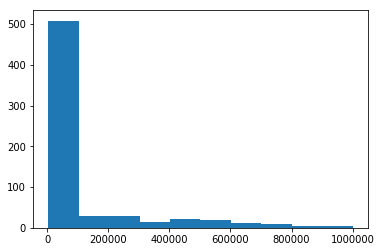

In [76]:
x = list(time_series_df['EXIT_DIFF'])
plt.hist(x, range=(4000,1000000));

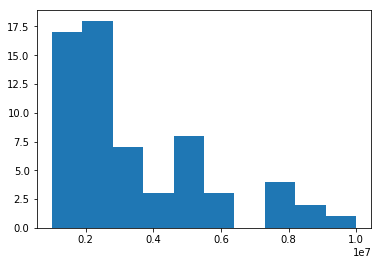

In [77]:
x = list(time_series_df['EXIT_DIFF'])
plt.hist(x, range=(1000000,10000000));

In [161]:
time_series_df = time_series_df[time_series_df.EXIT_DIFF < 500000]

In [163]:
time_series_df.shape

(2519805, 13)

**Pickle file with all positive, capped time interval data**

In [167]:
with open('cleaned_4hr_interval_mta.pickle', 'wb') as to_write:
    pickle.dump(time_series_df, to_write)

In [169]:
with open('cleaned_4hr_interval_mta.pickle','rb') as read_file:
    time_series_df = pickle.load(read_file)

**Entries per day at each subway station**

In [153]:
grouping = ['STATION','DATE']

In [182]:
daily_entries_per_station = time_series_df.groupby(by=grouping)['ENTRY_DIFF'].sum().reset_index()

In [183]:
daily_entries_per_station['ENTRY_DIFF'].max()

897951.0

In [184]:
zero_mask = (daily_entries_per_station.ENTRY_DIFF == 0)
daily_entries_per_station[zero_mask].shape[0]

151

**Remove days with zero entries from the dataset**

In [185]:
daily_entries_per_station = daily_entries_per_station[daily_entries_per_station.ENTRY_DIFF != 0]

In [186]:
daily_entries_per_station.shape

(33872, 3)

**Find top 20 stations by average daily entries: by STATION**

In [187]:
mean_entries_per_station = daily_entries_per_station.groupby(by=['STATION'])['ENTRY_DIFF'].mean().reset_index()

In [188]:
mean_entries_per_station.sort_values(by="ENTRY_DIFF", ascending=False).head(20)

,STATION,ENTRY_DIFF
60,34 ST-PENN STA,148853.472527
232,GRD CNTRL-42 ST,125024.857143
58,34 ST-HERALD SQ,98418.098901
45,23 ST,97239.186813
14,14 ST-UNION SQ,96659.197802
352,TIMES SQ-42 ST,89847.736264
225,FULTON ST,83808.208791
67,42 ST-PORT AUTH,82937.736264
109,86 ST,73454.659341
9,125 ST,67548.054945


**Find top 20 stations by average daily entries: by STATION AND SUBWAY LINES**

In [201]:
grouping = ['STATION','DATE', 'LINENAME']

In [202]:
daily_entries_per_station_line = time_series_df.groupby(by=grouping)['ENTRY_DIFF'].sum().reset_index()

In [203]:
daily_entries_per_station_line['ENTRY_DIFF'].max()

897951.0

In [204]:
zero_mask = (daily_entries_per_station_line.ENTRY_DIFF == 0)
daily_entries_per_station_line[zero_mask].shape[0]

207

**Remove days with zero entries from the dataset**

In [205]:
daily_entries_per_station_line= daily_entries_per_station_line[daily_entries_per_station_line.ENTRY_DIFF != 0]

In [206]:
daily_entries_per_station_line.shape

(42746, 4)

In [207]:
mean_entries_per_station_line = daily_entries_per_station_line.groupby(by=['STATION', 'LINENAME'])['ENTRY_DIFF'].mean().reset_index()

In [208]:
mean_entries_per_station_line.sort_values(by="ENTRY_DIFF", ascending=False).head(20)

,STATION,LINENAME,ENTRY_DIFF
312,GRD CNTRL-42 ST,4567S,125024.857143
89,34 ST-HERALD SQ,BDFMNQRW,98418.098901
93,34 ST-PENN STA,ACE,75667.384615
102,42 ST-PORT AUTH,ACENQRS1237W,70429.736264
28,14 ST-UNION SQ,LNQR456W,67863.923077
448,TIMES SQ-42 ST,1237ACENQRSW,56893.021978
302,FULTON ST,2345ACJZ,52988.000000
125,59 ST COLUMBUS,ABCD1,52297.000000
289,FLUSHING-MAIN,7,50873.912088
404,PATH NEW WTC,1,47102.956044


**Check for outrageously high exit values from the 4-hour time intervals**

In [72]:
time_series_df['EXIT_DIFF'].max()

1838305740.0

##### **Get 99th percentile of data**  
This value is very low - because there are many zeros in the dataset for 4-hour intervals where no one went in the subway (12am-4am at smaller stations for example), the confidence interval shifts to the left. We might be better off capping data at 500,000 and seeing how the data looks. 

**Entries per day at each subway station**

In [79]:
grouping = ['STATION','DATE']

In [80]:
daily_exits_per_station = time_series_df.groupby(by=grouping)['EXIT_DIFF'].sum().reset_index()

In [81]:
daily_exits_per_station['EXIT_DIFF'].max()

963710.0

In [83]:
zero_mask = (daily_exits_per_station.EXIT_DIFF == 0)
daily_exits_per_station[zero_mask].shape[0]

207

**Remove days with zero entries from the dataset**

In [85]:
daily_exits_per_station = daily_exits_per_station[daily_exits_per_station.EXIT_DIFF != 0]

In [86]:
daily_exits_per_station.shape

(33821, 3)

**Merge exit data with entrance data**

**Find top 20 stations by average daily entries: by STATION**

In [187]:
mean_entries_per_station = daily_entries_per_station.groupby(by=['STATION'])['ENTRY_DIFF'].mean().reset_index()

In [188]:
mean_entries_per_station.sort_values(by="ENTRY_DIFF", ascending=False).head(20)

,STATION,ENTRY_DIFF
60,34 ST-PENN STA,148853.472527
232,GRD CNTRL-42 ST,125024.857143
58,34 ST-HERALD SQ,98418.098901
45,23 ST,97239.186813
14,14 ST-UNION SQ,96659.197802
352,TIMES SQ-42 ST,89847.736264
225,FULTON ST,83808.208791
67,42 ST-PORT AUTH,82937.736264
109,86 ST,73454.659341
9,125 ST,67548.054945


**Find top 20 stations by average daily entries: by STATION AND SUBWAY LINES**

In [201]:
grouping = ['STATION','DATE', 'LINENAME']

In [202]:
daily_entries_per_station_line = time_series_df.groupby(by=grouping)['ENTRY_DIFF'].sum().reset_index()

In [203]:
daily_entries_per_station_line['ENTRY_DIFF'].max()

897951.0

In [204]:
zero_mask = (daily_entries_per_station_line.ENTRY_DIFF == 0)
daily_entries_per_station_line[zero_mask].shape[0]

207

**Remove days with zero entries from the dataset**

In [205]:
daily_entries_per_station_line= daily_entries_per_station_line[daily_entries_per_station_line.ENTRY_DIFF != 0]

In [206]:
daily_entries_per_station_line.shape

(42746, 4)

In [207]:
mean_entries_per_station_line = daily_entries_per_station_line.groupby(by=['STATION', 'LINENAME'])['ENTRY_DIFF'].mean().reset_index()

In [208]:
mean_entries_per_station_line.sort_values(by="ENTRY_DIFF", ascending=False).head(20)

,STATION,LINENAME,ENTRY_DIFF
312,GRD CNTRL-42 ST,4567S,125024.857143
89,34 ST-HERALD SQ,BDFMNQRW,98418.098901
93,34 ST-PENN STA,ACE,75667.384615
102,42 ST-PORT AUTH,ACENQRS1237W,70429.736264
28,14 ST-UNION SQ,LNQR456W,67863.923077
448,TIMES SQ-42 ST,1237ACENQRSW,56893.021978
302,FULTON ST,2345ACJZ,52988.000000
125,59 ST COLUMBUS,ABCD1,52297.000000
289,FLUSHING-MAIN,7,50873.912088
404,PATH NEW WTC,1,47102.956044


**Check if there are unique STATION-LINENAME combinations**  

Some info about the variables: "a control area is kind of like a 'station' for a specific line, a remote unit is kind of like a 'booth' so the same station can have a couple booths, and the subunit channel position could represent a turnstile, but could also represent a collection of turnstiles"

In [45]:
time_series_df.groupby(by=['STATION', 'LINENAME']).ngroups

477

In [46]:
time_series_df.groupby(by=['STATION']).ngroups

377

In [47]:
time_series_df.groupby(by=['UNIT', 'STATION', 'LINENAME']).ngroups

496

In [48]:
time_series_df.groupby(by='UNIT').ngroups

468